# Basic use of the `OptimizationResult` object and methods

After familiarizing yourself with the `Monte_Carlo` method from the `Optimizer` class you may seek basic or sophisticated analysis methods of your parameter-to-output dependencies. The `OptimizationResult` object essentially has two major functions:  
**1)** Retrieve, organize, and archive relevant ouput metadata and simulation data; and  

**2)** Povide methods to compare multiple simulation output based on differenet model performance metrics including giving the user access to the file path locations of relevant model inputs and outputs. 

In [2]:
from prms_python import Data, Optimizer, Parameters, util
from prms_python.optimizer import OptimizationResult
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib, json, os
import warnings; warnings.simplefilter('ignore')
matplotlib.style.use('ggplot')
%matplotlib inline

params = Parameters('../test/data/models/lbcd/parameters')
data = Data('../test/data/models/lbcd/data')
control = '../test/data/models/lbcd/control'
work_directory = '../test/results/'
measrd = '../test/data/fake_measured_swrad_lbcd.csv'

# `OptimizationResult` attributes

Attributes of the `OptimizationResult` class allow for custom workflows for analysis of Mote Carlo optimization output. In particular they give the user access to the original parameter set and model output, the measured time series of the optimized variable, and paths to all simulations that had parameters modified. 

In [3]:
stage = 'ddsolrad'
cust_res = OptimizationResult(work_directory, stage=stage)

In [4]:
# directory of the original simulation's input files
cust_res.input_dir

'../test/data/models/lbcd'

In [5]:
# path to original parameter file
cust_res.input_params

['../test/data/models/lbcd/parameters']

In [6]:
# name of the PRMS statistical variable that is being optimized
cust_res.statvar_name

'swrad_2490'

In [7]:
# the optimization stage, can be named arbitrarily in this case we use the name of the 
# PRMS solar radiation module 
cust_res.stage

'ddsolrad'

In [8]:
# the OptimizationResult.measured attribute holds a Pandas.Series object of the 
# measured variable that is being optimized
cust_res.measured.head()

1937-10-01    447.752204
1937-10-02    441.216580
1937-10-03    410.682145
1937-10-04    176.349945
1937-10-05    126.152800
dtype: float64

In [9]:
# the working_dir is the directory where PRMS-Python will look for Optimizer JSON files
cust_res.working_dir

'../test/results/'

In [10]:
# list of paths to of all metadata JSON files corresponding given optimization stage
cust_res.metadata_json_paths

{'ddsolrad': ['../test/results/testing_srad_ddsolrad_opt.json']}

The location of each parameter set that was modified in an individual optimization run is stored in the JSON metadata files. More on this can be found in the Jupyter notebook titled "monte_carlo_param_resampling". Below is an example showing how modified parameter sets may be accessed using `OptimizationResult.metadata_json_paths`. Another perhaps more convenient way of accessing parameters along with their outputs based on their output performance is demonstrated later in this notebook.

In [11]:
# get a JSON file path from the list, in this case the first JSON corresponds with the first optimization run
json_path = cust_res.metadata_json_paths[cust_res.stage][0]

fh = open(json_path)
json_data = json.load(fh)
json_data

{'end_datetime': '2018-08-21T00:03:38.932987',
 'measured': '../test/data/fake_measured_swrad_lbcd.csv',
 'method': 'Monte Carlo',
 'mu_factor': 1,
 'n_sims': 4,
 'noise_factor': 0.1,
 'nproc': 4,
 'optimization_description': None,
 'optimization_title': 'testing_srad',
 'original_params': '../test/data/models/lbcd/parameters',
 'params_adjusted': ['tmax_index', 'dday_intcp'],
 'resample': 'normal',
 'sim_dirs': ['../test/results/tmax_index_51.4479452114',
  '../test/results/tmax_index_50.4660898301',
  '../test/results/tmax_index_51.6971617025',
  '../test/results/tmax_index_54.9281475979'],
 'stage': 'ddsolrad',
 'start_datetime': '2018-08-21T00:03:23.733736',
 'statvar_name': 'swrad_2490'}

As we can see the JSON metadata does not hold information on which simulation performed best. However we can access all stored metadata directly using this method. If the given optimization stage, in this case 'ddsolrad', was created using multiple instances of an Optimizer object then there will be multiple JSON files each with its own information. If for example we wanted to know the method used for resampling from an individual Optimizer run we can use the `.get` method of the JSON dictionary as shown below.

In [12]:
json_data.get('resample') # which param resampling method was used for this Optimizer run 

'normal'

# Using `OptimizationResult` methods to compare results and access parameter and output sets that correspond with each other.

There are currently two major methods of the `OptimizationResult`. The `.result_table` allows the user to rank simulations using four objective functions on the optimization variable. The `.get_tope_ranked_sims` is used to map input parameters to simulation outputs according to the ranked models. We rank by maximizing the daily or monthly Nash Sutcliffe Efficiency (NSE) and the coefficient of determination (COEF_DET), minimizing root mean squared error (RMSE) and percent bias (PBIAS). 

In [13]:
ddsolrad_res = OptimizationResult(work_directory, stage=stage)

# note, when using monthly frequency the optimization variable is averaged (mean simulated and mean observed)
top10 = ddsolrad_res.result_table(freq='monthly',top_n=10)
top10

ddsolrad parameters,NSE,RMSE,PBIAS,COEF_DET
orig_params,0.956267,39.4725,-0.885715,0.963116
tmax_index_51.4479452114,0.784284,78.9851,-3.25805,0.798881
tmax_index_51.6971617025,0.77183,81.2332,-4.32865,0.854146
tmax_index_50.4660898301,0.678053,96.4931,-9.9341,0.852113
tmax_index_54.9281475979,0.369017,135.087,-14.6662,0.767133


The `result_table` method sorts all simulations by NSE followed by RMSE, PBIAS, and lastly COEF_DET. The index of the dataframe is the name of the simulation which follows the naming convention of the `Optimizer.monte_carlo` method that uses the name of the first parameter that is resampled and it's mean value to 10 decimals. Because the result is a DataFrame it is possible to sort simulations by any of the columns as opposed to weighting NSE highest. 

---

## Mapping parameters to outputs example
The `OptimizationResult.get_top_ranked_sims` method takes a `Optimization.result_table` and returns a dictionary that includes four lists: the ranked simulation names; the parameter paths for each simulation; the parameters that were adjusted for each simulation (may be a list of parameters if more than one was adjusted); and the stavar file paths for each simulation. In each case these are indexed in the order of the `result_table` that is passed to the function as shown below.

In [14]:
mappnig_dic = ddsolrad_res.get_top_ranked_sims(top10)
mappnig_dic

{'dir_name': ['tmax_index_51.4479452114',
  'tmax_index_51.6971617025',
  'tmax_index_50.4660898301',
  'tmax_index_54.9281475979'],
 'param_path': ['../test/results/tmax_index_51.4479452114/inputs/parameters',
  '../test/results/tmax_index_51.6971617025/inputs/parameters',
  '../test/results/tmax_index_50.4660898301/inputs/parameters',
  '../test/results/tmax_index_54.9281475979/inputs/parameters'],
 'statvar_path': ['../test/results/tmax_index_51.4479452114/outputs/statvar.dat',
  '../test/results/tmax_index_51.6971617025/outputs/statvar.dat',
  '../test/results/tmax_index_50.4660898301/outputs/statvar.dat',
  '../test/results/tmax_index_54.9281475979/outputs/statvar.dat'],
 'params_adjusted': [['tmax_index', 'dday_intcp'],
  ['tmax_index', 'dday_intcp'],
  ['tmax_index', 'dday_intcp'],
  ['tmax_index', 'dday_intcp']]}

A common workflow will require analysis of both good results and the parameters that gave such results. 
The `OptimizationResult.get_top_ranked_sims` and `Optimization.result_table` allow for basic access to model input and output paths as well as other metadata. Below we show simple visualization of the top 3 parameter sets for the solar radiation parameter random sample (Monte Carlo). 

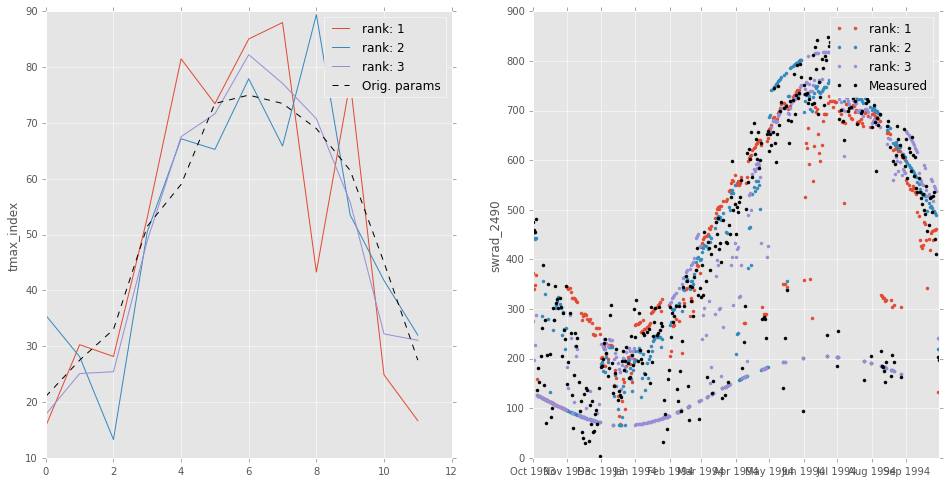

In [15]:
# dates for one year of output on plot
dates = pd.date_range(start='1993-10-01', end='1994-09-30')

fig, axes = plt.subplots(1,2, figsize = (16,8))

for i in range(3):
    rank = i+1
    params = mappnig_dic.get('params_adjusted')[i]
    n_params = len(params)
    param_file = mappnig_dic.get('param_path')[i]
    adj_param = Parameters(param_file)[params[0]]
    axes[0].plot(adj_param, label='rank: {}'.format(rank))
    axes[0].set_ylabel(params[0])

    statvar_file = mappnig_dic.get('statvar_path')[i]      
    statvar = util.load_statvar(statvar_file)[ddsolrad_res.statvar_name]
    axes[1].plot(statvar.loc[dates], '.', label='rank: {}'.format(rank))
    axes[1].set_ylabel(ddsolrad_res.statvar_name)

    
original_param = Parameters(ddsolrad_res.input_params[0])[params[0]]
axes[0].plot(original_param, 'k--', label='Orig. params')    
axes[0].legend()

axes[1].plot(ddsolrad_res.measured.loc[dates], 'k.', label='Measured')    
axes[1].legend()

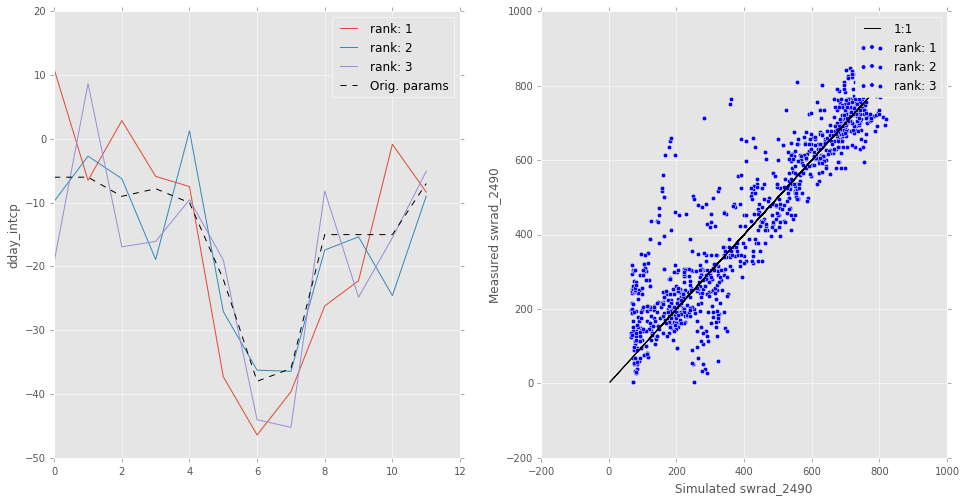

In [16]:
# similar for second parameter adjusted (dday_intcp)
fig, axes = plt.subplots(1,2, figsize = (16,8))

for i in range(3):
    rank = i+1
    params = mappnig_dic.get('params_adjusted')[i]
    n_params = len(params)
    param_file = mappnig_dic.get('param_path')[i]
    adj_param = Parameters(param_file)[params[1]]
    axes[0].plot(adj_param, label='rank: {}'.format(rank))
    axes[0].set_ylabel(params[1])

    statvar_file = mappnig_dic.get('statvar_path')[i]      
    statvar = util.load_statvar(statvar_file)[ddsolrad_res.statvar_name]
    axes[1].scatter(statvar.loc[dates], ddsolrad_res.measured.loc[dates], label='rank: {}'.format(rank))
   
original_param = Parameters(ddsolrad_res.input_params[0])[params[1]]
axes[0].plot(original_param, 'k--', label='Orig. params')    
axes[0].legend()
axes[1].set_ylabel('Measured {}'.format(ddsolrad_res.statvar_name))
axes[1].set_xlabel('Simulated {}'.format(ddsolrad_res.statvar_name))
axes[1].plot(ddsolrad_res.measured.loc[dates], ddsolrad_res.measured.loc[dates], 'k-', label='1:1')    
axes[1].legend()

# Using `OptimizationResult.archive` method to reduce disk space from large Monte Carlo simulations and retain important information

The archive method by default keyword options deletes the original simulation directories and input/output files of PRMS resulting in a great reduction in used disk space. Before deletion the method utilizes Optimizer metadata json files to track the simulations of a given stage that the OptimizationResult object was initiated with, it then opens the parameter files and statvar.dat files of each simulation and saves the modified parameter names and values along with the time series of the statistical output variable that is being optimized on (e.g. streamflow) to a new archived JSON file. Other data such as the parameter resampling method is also saved to the archived JSON files. The method puts these archived JSON files in a new subdirectory named "[stage]_archived". 

### *Note of caution* 

The archive method will remove all other simulations (or other files and folders) that are not tracked by the current optimization stage,  the method does not however remove any other archive subdirectories. Therefore if you are running multiple Monte Carlo optimizers at once, e.g. on a computer cluster in parallel you will want to create separate working directories for each instance otherwise the archiving function may delete simulations from other Optimization routines before they are archived (from experience!) . In general however, if you are iterating over multiple `Optimizer.monte_carlo` routines but only running one at a time (common) using different stages you should be fine to use the same working directory for all simulations. 

In [17]:
def get_size(start_path = '.'):
    """ 
        function to calculate disk space recorsively of a directory from:
        https://stackoverflow.com/questions/1392413/calculating-a-directorys-size-using-python 
    """
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size

print("working directory size before archiving: {:.0f} MB".format(get_size(work_directory) / 10**6 ))

# calculate performance metrics on monthly mean output vs measured when archiving
ddsolrad_res.archive(metric_freq="monthly") 

print("working directory size after archiving: {:.1f} MB".format(get_size(work_directory) / 10**6 ))

working directory size before archiving: 464 MB
working directory size after archiving: 0.3 MB


In [18]:
# all Simulation directories have been removed,
# note- there is a boolean keyword argument "remove_meta" that optionally deletes original metadata set true
os.listdir(work_directory)

['ddsolrad_archived', 'testing_srad_ddsolrad_opt.json']

In [19]:
# and the new archive JSON files are within the archived directory:
os.listdir(os.path.join(work_directory, 'ddsolrad_archived'))

['tmax_index_50.4660898301.json',
 'tmax_index_51.4479452114.json',
 'tmax_index_51.6971617025.json',
 'tmax_index_54.9281475979.json']

In [20]:
# open a single JSON file
with open(os.path.join(work_directory, 'ddsolrad_archived', 'tmax_index_50.4660898301.json')) as f:
    archive_file = json.load(f)

# print a list of the keys for each entry in the archived JSON file
print('List of keys in archived JSON file:\n'+'-'*35)
print('\n'.join([f for f in archive_file.keys()]))

List of keys in archived JSON file:
-----------------------------------
COEF_DET
NSE
PBIAS
RMSE
measured_path
metric_freq
mu_factor
noise_factor
original_param_path
output_date_index
output_name
output_values
param_names
param_values
resample
stage


Model performance metrics (NSE, COEF_DET, PBIAS, RMSE) are calculated and recorded in the archived JSON files for convenience. These metrics are calculated on either daily or monthly means between the measured data and the corresponding statistical output variable (name) that were necessary to call the Optimizer.monte_carlo method for each Monte Carlo implementation of the given stage. The file paths to the original or unaltered parameter file and the measured data is provided for ease of post processing and model comparisons.

In [21]:
# access the archive as a Python dictionary
archive_file.get('stage')

'ddsolrad'

In [22]:
archive_file.get('resample')

'normal'

In [23]:
archive_file.get('param_names')

['tmax_index', 'dday_intcp']

In [24]:
archive_file.get('param_values')

[[17.773118630451474,
  25.0999613753539,
  25.42387635286766,
  48.91685211172789,
  67.54997338262592,
  71.63529559990603,
  82.24234113218249,
  77.1012697501826,
  70.76581036501278,
  55.82360124645164,
  32.19886489579664,
  31.062113118348705],
 [-19.21701813814721,
  8.691253931221718,
  -16.913973400055824,
  -16.075307466994555,
  -9.535743486427437,
  -18.973344222105908,
  -44.03032441471215,
  -45.2175532193168,
  -8.189950107801238,
  -24.815215785908567,
  -15.504883375337561,
  -5.08709301821418]]

## Reconstruct a pandas series object from archived JSON files easily for further analysis of results

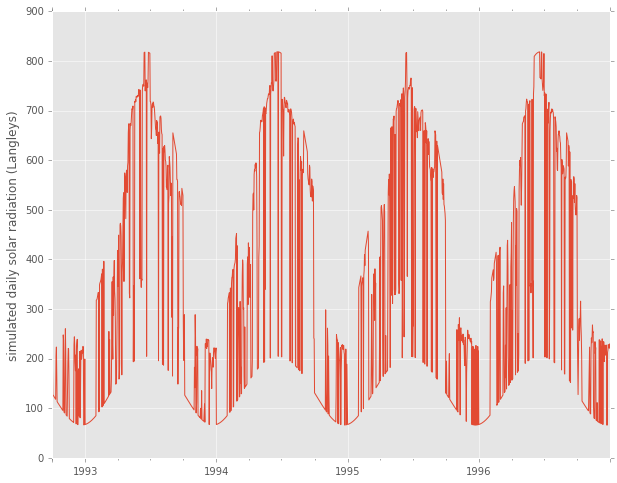

In [25]:
idx = pd.to_datetime(archive_file.get('output_date_index'))
output = archive_file.get('output_values')
output_series = pd.Series(data=output, index=idx)

ax = output_series.plot(figsize=(10,8))
ax.set_ylabel('simulated daily solar radiation (Langleys)')